The set of positive definite matrices (PSD) form a cone in Hilbert space. Hi-C matrices are semi-positive definite or even PSD (after excluding zero columns). If Hi-C matrices lies on a cone, it's very convenient to introduce a natural metric on this kind of a manifold.

# Diagonal correlation

Diagonals of Hi-C can be treated as normally distributed random value. Surely, diagonals on small separation distance will have high correlation (for example, due to underlying TAD structure). Thus we can consider diagonals of Hi-C map as random vector sampled from joint Gaussian distribution. This assumption provides us a method for computing a distance between such a distributions.

In [1]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy import interpolate
from scipy.linalg import sqrtm
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

6

In [2]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'

In [62]:
RESOLUTION = 25_000
downsampled = True
merged = False

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
    else:
        FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
else:
    FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
    CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]

CLRS_DICT = dict(zip([basename(c.filename).split('_')[1] for c in CLRS], CLRS)) #### tmp!

#compartments
eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*lam.txt'))
eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*vecs.txt'))
eigvec = {l:pd.read_csv(f, sep='\t') for l, f in zip(['KO', 'WT', 'old', 'young'], eigvec_files)}
eigval = {l:pd.read_csv(f, sep='\t', index_col=1) for l, f in zip(['KO', 'WT', 'old', 'young'], eigval_files)}

#insulation score
#IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [63]:
# work with 5-th chromosome
c = CLRS[0]
mat = c.matrix(balance=False).fetch('chr5')

#prepare matrix
mask = ~(mat == 0).all(axis=1)
mat = mat[:, mask][mask, :]
#corr
mat = np.corrcoef(mat)

In [68]:
#three kinds of correlation
k=150 #number of diagonals in the scope
exclude = 0

#upper
diagsU = np.stack([mat.diagonal(i)[:-(k-i)] for i in range(k)], axis=0) 
CU = np.corrcoef(diagsU)

#lower
diagsL = np.stack([mat.diagonal(i)[(k-i):] for i in range(k)], axis=0) 
CL = np.corrcoef(diagsL)

#interpolation
from scipy import interpolate
main_diag = mat.diagonal(0)
dsize = main_diag.shape[0]
diagsI = []
for i in range(k):
    d = mat.diagonal(i)
    x = np.linspace(0, 1, d.shape[0])
    f = interpolate.interp1d(x, d)
    xnew = np.linspace(0, 1, dsize)
    diagsI.append(f(xnew))
diagsI = np.stack(diagsI, axis=0)
CI = np.corrcoef(diagsI)


In [69]:
np.corrcoef(diagsU[2], diagsU[3])

array([[1.        , 0.68991006],
       [0.68991006, 1.        ]])

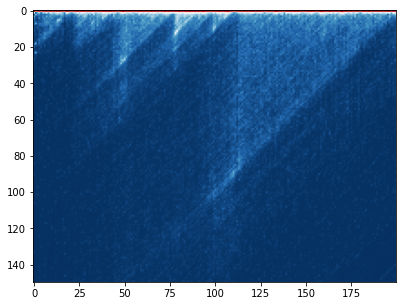

In [70]:
plt.figure(figsize=(15,5))
plt.imshow(np.log10(diagsU[:, :200]+1), cmap='RdBu_r')

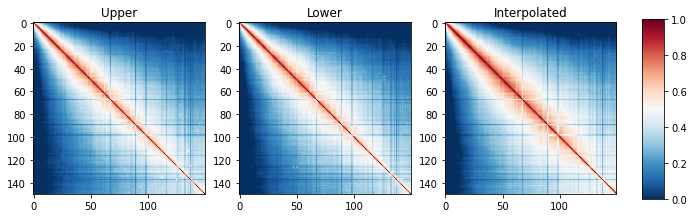

In [71]:
fig, axes = plt.subplots(1,3, figsize=(12,5))
img = axes[0].imshow(CU, cmap='RdBu_r', vmax=1., vmin=0)
axes[1].imshow(CL, cmap='RdBu_r', vmax=1., vmin=0)
axes[2].imshow(CI, cmap='RdBu_r', vmax=1., vmin=0)
axes[0].set_title('Upper')
axes[1].set_title('Lower')
axes[2].set_title('Interpolated')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.025, 0.5])
fig.colorbar(img, cax=cbar_ax)

In [83]:
k=150 #number of diagonals in the scope
exclude = 0

#upper
def diag_cov(mat, k=100, exclude=None, method='upper', corr=False):
    if method == 'upper':
        diags = np.stack([mat.diagonal(i)[:-(k-i)] for i in range(k)], axis=0) 
    elif method == 'lower':
        diags = np.stack([mat.diagonal(i)[(k-i):] for i in range(k)], axis=0) 
    elif method == 'interpolation':
        dsize = mat.diagonal(0).shape[0]
        diags = []
        for i in range(k):
            d = mat.diagonal(i)
            x = np.linspace(0, 1, d.shape[0])
            f = interpolate.interp1d(x, d)
            xnew = np.linspace(0, 1, dsize)
            diags.append(f(xnew))
        diags = np.stack(diags, axis=0)
    else:
        NotImplementedError()
    
    func = np.corrcoef if corr else np.cov
    if exclude is not None:
        C = func(diags[exclude+1:, :])
    else:
        C = func(diags)
    return C


def compute_w2(x, y):
    x_root = sqrtm(x)
    cross_term = 2 * sqrtm(x_root @ y @ x_root)
    w2 = np.trace(x + y - cross_term)
    return w2

def compute_frob(x, y):
    return np.linalg.norm(x - y, ord='fro')

# work with 5-th chromosome
covariances = []
for c in CLRS:
    mat = c.matrix(balance=False).fetch('chr10')
    
    #prepare matrix
    mask = ~(mat == 0).all(axis=1)
    mat = mat[:, mask][mask, :]
    #mat = np.log10(mat + 1)
    #corr
    mat = np.sqrt(np.corrcoef(mat) + 1)
    
    cov = diag_cov(mat, k=k, exclude=exclude, method='upper', corr=True)
    covariances.append(cov)
    
distances = np.zeros((len(covariances), len(covariances)))
frob_dist = np.zeros((len(covariances), len(covariances)))
for i in range(len(covariances)):
    for j in range(i, len(covariances)):
        dist = compute_w2(covariances[i], covariances[j])
        distances[i, j] = dist
        distances[j, i] = dist
        
        fro = compute_frob(covariances[i], covariances[j])
        frob_dist[i, j] = fro
        frob_dist[j, i] = fro


In [84]:
LABELS = ['_'.join(basename(c.filename).split('_')[0:2]) for c in CLRS]
distance_frame = pd.DataFrame(distances, columns=LABELS, index=LABELS)
frob_frame = pd.DataFrame(frob_dist, columns=LABELS, index=LABELS)

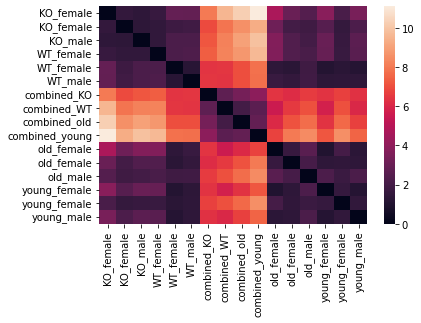

<AxesSubplot:>

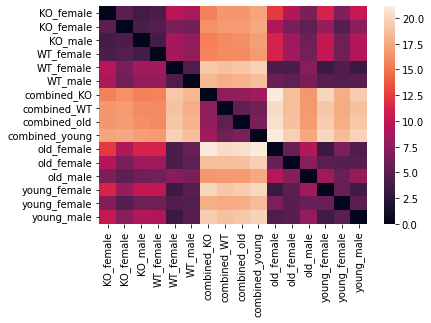

In [85]:
sns.heatmap(distance_frame)
plt.show()
sns.heatmap(frob_frame)

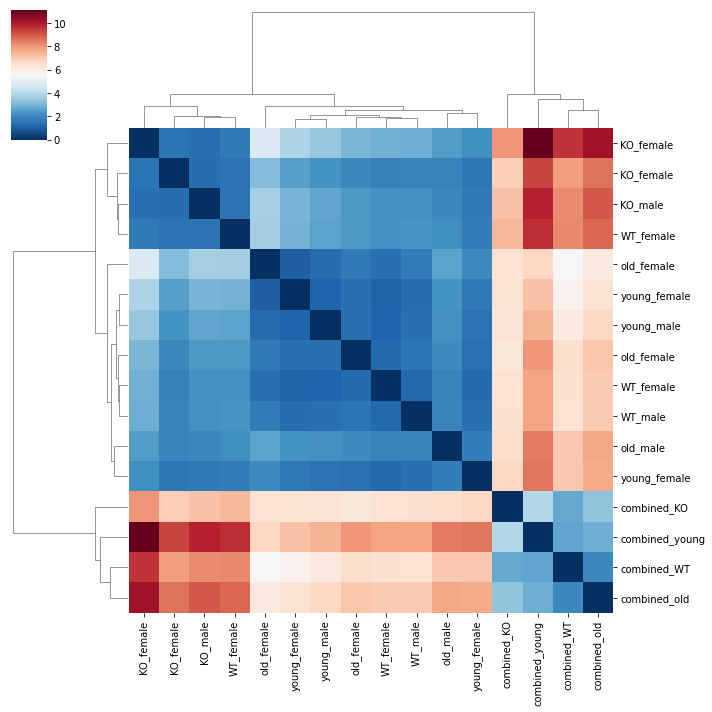

In [86]:
#k=20; exclude = 10 - KO and Old in separate clusters (chr5)

sns.clustermap(distance_frame, cmap='RdBu_r')

In [2]:
p = '/tank/projects/omics2022/efimov/METH/BULK/GSE186458_MET/GSE186458_met_mtx_multi.tsv'

In [7]:
with open(p, 'r') as f:
    for i in range(2):
        l = f.readline()

In [9]:
len(l)
l[:100]

'GSM5652176\t0.6669999957084656\t0.3330000042915344\t0.6669999957084656\t1.0\t0.5\t0.5\t0.75\t0.4289999902248'

In [10]:
k = l.split('\t')

In [11]:
k[:3]

['GSM5652176', '0.6669999957084656', '0.3330000042915344']